In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy import sparse
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import pickle

C:\Users\ashwin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ashwin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [6]:
X_train= sparse.load_npz('train_tfidf.npz')         #loading the sparse matrix
X_cv= sparse.load_npz('cv_tfidf.npz')
X_test= sparse.load_npz('test_tfidf.npz')

In [5]:
y_train= pd.read_pickle('y_train')                                #loading the true labels
y_cv= pd.read_pickle('y_cv') 
y_test= pd.read_pickle('y_test') 

In [7]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [9]:
test_len= len(y_test)

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.890406332722044


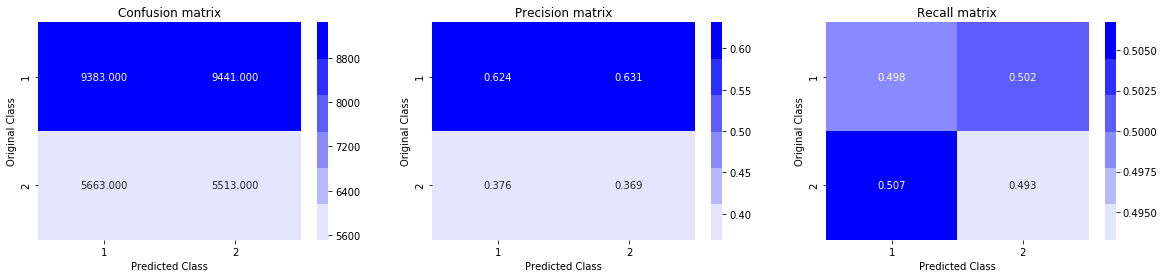

In [11]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4628248156566899
For values of alpha =  0.0001 The log loss is: 0.4635490310781471
For values of alpha =  0.001 The log loss is: 0.45758041043745834
For values of alpha =  0.01 The log loss is: 0.4583540479557229
For values of alpha =  0.1 The log loss is: 0.4596301339062383
For values of alpha =  1 The log loss is: 0.4938739275495117
For values of alpha =  10 The log loss is: 0.5503894811020347


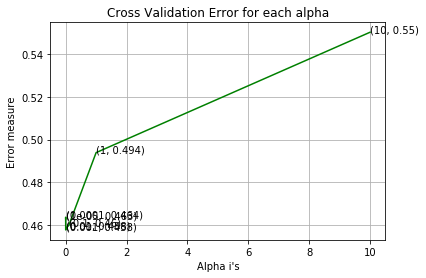

For values of best alpha =  0.001 The train log loss is: 0.4631925973121764
For values of best alpha =  0.001 The test log loss is: 0.4624834859878377
Total number of data points : 30000


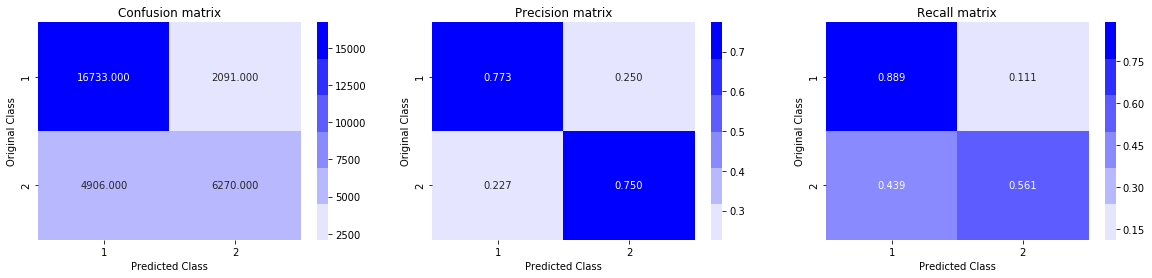

In [12]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4639310789526797
For values of alpha =  0.0001 The log loss is: 0.484553792700581
For values of alpha =  0.001 The log loss is: 0.49158210905297833
For values of alpha =  0.01 The log loss is: 0.4926120880835452
For values of alpha =  0.1 The log loss is: 0.5042605207323733
For values of alpha =  1 The log loss is: 0.5875819873698122
For values of alpha =  10 The log loss is: 0.6285632427194632


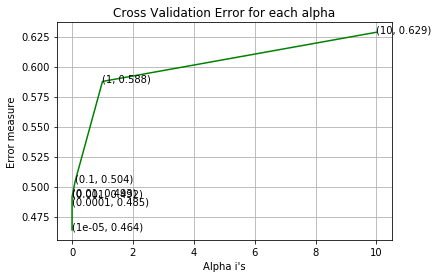

For values of best alpha =  1e-05 The train log loss is: 0.4726584890371186
For values of best alpha =  1e-05 The test log loss is: 0.46888247083234114
Total number of data points : 30000


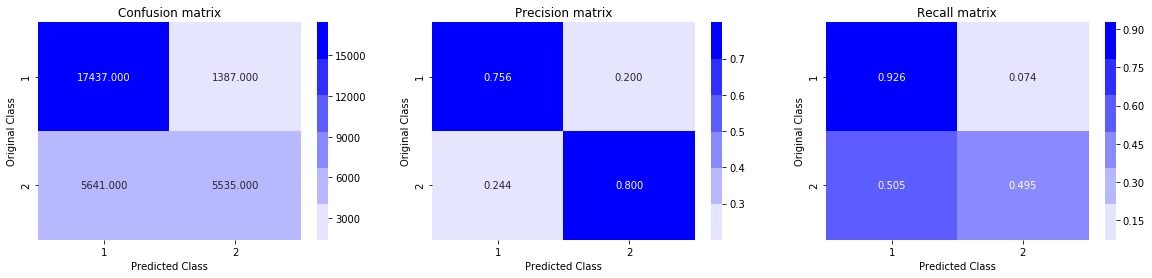

In [13]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [14]:
import xgboost as xgb
from scipy.stats import randint as sp_randint

In [15]:
def rscv_fn(clf, p_distr,X,y):
    '''This function is to perform hyperparameter tuning using the RandomizedSearchCV and get the best parameters'''
    rndm_srch = RandomizedSearchCV(clf, param_distributions=p_distr , scoring='log_loss',
                                  n_jobs=-1)
    rndm_srch.fit(X,y)
    bst_params = rndm_srch.best_params_
    bst_score = rndm_srch.best_score_
    cv_results= rndm_srch.cv_results_
    return bst_params, bst_score ,cv_results

In [16]:
clf = xgb.XGBClassifier(objective='binary:logistic')
param_dist={'n_estimators':[100,250,500,750],      #dict of parameters
           'max_depth':sp_randint(1,10)
           }                  

In [17]:
warnings.filterwarnings('ignore')
bst_params, bst_score ,cv_results = rscv_fn(clf, param_dist , X_train, y_train)

In [18]:
print(bst_params)
print('Hyper-tuned model score :')
print(bst_score)

{'max_depth': 7, 'n_estimators': 500}
Hyper-tuned model score :
-0.32576959904005676


In [19]:
clf=xgb.XGBClassifier(max_depth=7, n_estimators=500 , objective='binary:logistic',n_jobs=-1)

clf.fit(X_train , y_train)
predict_test= clf.predict_proba(X_test)

In [24]:
predict_train = clf.predict_proba(X_train)

In [26]:
print("log loss on the test data is :",log_loss(y_test,predict_test, labels=clf.classes_))
print("log loss on the train data is :",log_loss(y_train,predict_train, labels=clf.classes_))

log loss on the test data is : 0.3203122402669013
log loss on the train data is : 0.22454529825749367


Total number of data points : 30000


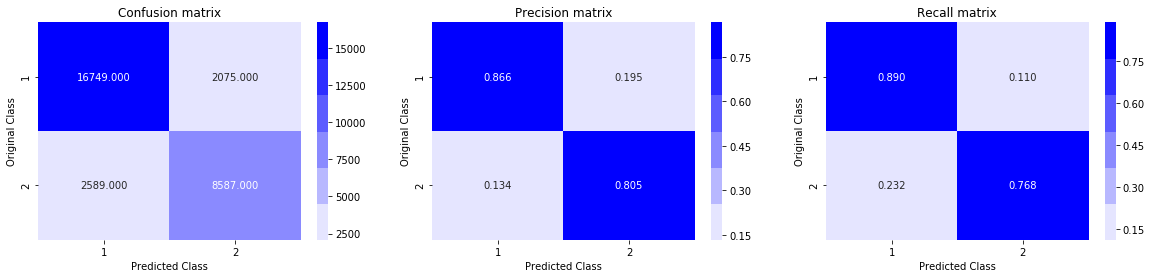

In [21]:
predicted_y=np.argmax(predict_test,axis=1)

print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

In [22]:
from prettytable import PrettyTable

In [23]:
x= PrettyTable()

In [27]:
x.field_names=['Model name','train loss','test loss']
x.add_row(['Logistic regression','0.4631','0.4624'])
x.add_row(['SVM','0.4726','0.4688'])
x.add_row(['XGBoost','0.2245','0.3203'])
print(x)

+---------------------+------------+-----------+
|      Model name     | train loss | test loss |
+---------------------+------------+-----------+
| Logistic regression |   0.4631   |   0.4624  |
|         SVM         |   0.4726   |   0.4688  |
|       XGBoost       |   0.2245   |   0.3203  |
+---------------------+------------+-----------+


**** Steps followed in the case study ****

- __Data analysis__ : 1) We loaded the data and checked for the duplicates, unique questions ,null values .

- __Basic Feature Extraction__ : 2) We performed the basic feature extraction with features: freq_qid1, freq_qid2 ,q1_len ,q2_len , q1_n_words ,q2_n_words ,word_common ,word_Total ,word_share,freq_q1+freq_q2 ,freq_q1-freq_q2 .

- __EDA on basic features__ : 3) We plotted violin plots , contour plots and distribution plots with the basic features and pointed the best features.

- __Advanced feature extraction__ : 4) We performed the advanced feature extraction using the features: cwc_min ,cwc_max, ctc_min, ctc_max, csc_min, csc_max , last_word_eq, first_word_eq ,abs_len_diff ,mean_len ,fuzz_ratio ,fuzz_partial_ratio ,token_sort_ratio ,token_set_ratio , longest_substr_ratio .

- __EDA on advanced features__ : 5)We plotted the violin plots,contour plots and distributon plots with these advanced features and pointed the best features.

- __Data splitting__ :6) We split the data into train cv and test after h_stacking the basic , advanced features with the original dataframe. We took 100,000 points and performed random splitting.

- __Vectorization__ : 7) As our questions are still in the english form so we need to convert them to vectors using the TFIDF vectorizer , by training the tfidf on the train data and fitting the tfidf model on the cv and test data.

- __Models__ : 8) We build models like Logistic regression , linear SVM and XGBoost and interpretted the results using log_loss as the performance metric.

- __Conclusion__ : 9) We concluded the results using a prettytable .